# Notebook dedicated to the creation of figures from the csv files generated the notebook "Preprocessing"

____Alice Dauphin 2020_____


In [3]:
from __future__ import print_function
%xmode Verbose

%matplotlib notebook
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import numpy as np
import math
import scipy
import seaborn as sns
import networkx as nx
import re
import os

#For to have coherent background in graphs
plt.rcParams['axes.grid'] = True #setting the grid on throughout the script
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
jtplot.style(context='notebook', spines=False, gridlines='-',ticks=True)
#jtplot.reset() # reset default matplotlib rcParams

Exception reporting mode: Verbose


# Class and object definition

## Dictionary of primitive operations

In [2]:
dict_prims = {'V1toRT1': ['V1', 'RT1'],'V1toRT2' : ['V1', 'RT2'], 'V1toRT3': ['V1', 'RT3'],
              'V1toWM1': ['V1', 'WM1'],
              'V2toRT1': ['V2', 'RT1'], 'V2toRT2': ['V2', 'RT2'],  'V2toRT3': ['V2', 'RT3'],
              'V2toWM1': ['V2', 'WM1'],
              
              'RT1toAC1': ['RT1', 'AC1', 'AC2'], 'RT2toAC1': ['RT2', 'AC1', 'AC2'],
              'RT3toAC1': ['RT3', 'AC1', 'AC2'],
              'RT2toRT1': ['RT2', 'RT1'], 'RT3toRT2': ['RT3', 'RT2'],  
              
              'WM1toRT1': ['WM1', 'RT1'], 'WM1toRT2' : ['WM1','RT2'], 'WM1toRT3' : ['WM1','RT3'],
              'WM1toAC1': ['WM1', 'AC1','AC2'], 
              
              'RT2toWM1': ['RT2', 'WM1'], 'RT3toWM1': ['RT3', 'WM1'],
              
              'C1toRT1': ['C1', 'RT1'], 'C1altToRT1': ['C1alt', 'RT1'],
              'RT1equalC1': ['RT1', '==C1'], 'RT1equalC1alt': ['RT1','==C1alt' ], 
              'next-goal': ['C1', 'G2'],
              #'stage1': ['G2'],'stage2': ['G2'],
             }

## Group Of Sim

In [92]:
class GroupOfSim:
    """group all the sim done in one context"""
    def __init__(self):
        self.csv_sim = {}
   
    def fill_sim_from_csv(self, func, thresh, dist, indexMax, nbOfTrials):
        """fill the dict of simulations from the csv files previously exported"""
        self.function = func
        self.threshold = thresh
        self.distance = dist
        self.indexMax = indexMax
        self.nb0fTrials = nbOfTrials
        for i in range(self.indexMax+1):
            if func == 'random':
                filename = 'random/random_random_'+ str(i) +'.csv'
            if func == 'accuderiv':
                filename = 'accu_deriv/' + func + '_thsh' + str(thresh) + '_dist'+ str(dist)+ '_'+ str(i)+'.csv'
            if func == 'task_control':
                filename = 'tasks_control/' + func + str(nbOfTrials) + '_'+ str(i)+'.csv' 
            if func == 'control_noreset_test':
                filename = 'tasks_control/'+ func+'_' + str(i)+ '.csv'
            self.csv_sim[str(i)] = pd.read_csv(filename, sep=';', 
                    dtype = {'Ind':np.uint16, 'Task': "category" ,'Trial':np.uint16, 'Time':np.float64,
                    'goalBLActivation': np.float64,'reachGoal': np.bool_, 'Accuracy': np.float32,
                             'retrievedOperators': "str"}) #Load the data
            self.csv_sim[str(i)].set_index("Ind", inplace = True) #Re-establish the index from the 'Ind' column
            self.csv_sim[str(i)]= self.csv_sim[str(i)].iloc[0:10000] #we compare simulations of 10000 trials each
                
    def convergence_csv(self):
        """function that takes as input a Experiment.data object and generate (and save) a dataframe 
        containing for each simulation the trial from which the model can be considered to converge for
        each task"""
        self.convergence={}
        for i in range(self.indexMax+1):
            self.convergence[str(i)]=pd.Series(trial_convergence(self.csv_sim[str(i)]))
        self.summary_convergence= pd.DataFrame(self.convergence).T
        #Export the dataframe summary_convergence
        self.summary_convergence.index.name='Ind' #Name the index so the column will be named in the csv file
        if self.function == 'random':
            filename = 'random/convergence_random_'+ str(i) +'simulations.csv'
        if self.function == 'accuderiv':
            filename = 'accu_deriv/convergence_accuderiv_thsh' + str(self.threshold) + \
                '_dist'+ str(self.distance)+ '_'+ str(i)+'simulations.csv'
        if self.function == 'task_control':
            filename = 'tasks_control/convergence_task_control_' + str(self.nb0fTrials) + \
                'trials_'+ str(i)+'simulations.csv'
        if self.function == 'control_noreset':
            filename = 'tasks_control/convergence_control_noreset.csv'
        if self.function == 'control_noreset_test':
            filename = 'tasks_control/convergence_control_noreset_test.csv'    
        self.summary_convergence.to_csv(filename, sep=';', encoding='utf-8', header=True)   
        
    def category(self):
        self.category={}
        for i in range(self.indexMax+1):
            self.category[str(i)]=pd.Series(trial_convergence2(self.csv_sim[str(i)]))
        self.category= pd.DataFrame(self.category).T
        self.category.index.name='Ind'
        self.category.rename(columns={0: 'Convergence', 1: 'NumberOfTrials'}, inplace=True)

# Function definion

## Trial from which the model can be considered as convergent

### Find the trial

In [74]:
def trial_convergence(data):
    """function that takes as input a Experience.data object or a batchControl.data object and return a 
    dictionary in which keys are tasks and values are the first trials before skill acquisition (if there
    is convergence). The function finds the first trial in which accuracy > 0.8 (<=> accuracy >= 0.9 as 
    accuracy can takes only 1/10 values)"""
    first_trial = {}
    for task in data['Task'].cat.categories:
        df_task = data.loc[data.Task == task]
        df_task.set_index("Trial", inplace = True) #set the index to the trials relative to the task
        values = np.where(df_task['Accuracy'] < 0.8)
        if len(values[0]) > 0:
            if np.amax(values[0]) < (len(df_task['Accuracy']) - 50):
                first_trial[task] = np.amax(values[0])
            else:
                first_trial[task] = -1
        else:
            first_trial[task] = -1
    return(first_trial)

In [75]:
def trial_convergence2(data):
    """function that takes as input a Experience.data object or a batchControl.data object and return a 
    dictionary in which keys are tasks and values are the first trials before skill acquisition (if there
    is convergence). The function finds the first trial in which accuracy > 0.8 (<=> accuracy >= 0.9 as 
    accuracy can takes only 1/10 values)"""
    first_trial = {}
    task= 'category'
    df_task = data.loc[data.Task == task]
    df_task.set_index("Trial", inplace = True) #set the index to the trials relative to the task
    values = np.where(df_task['Accuracy'] < 0.8)
    if len(values[0]) > 0:
        if np.amax(values[0]) < (len(df_task['Accuracy']) - 50):
            first_trial[task] = True
        else:
            first_trial[task] = False 
    else:
        first_trial[task] = False
    return(first_trial[task], len(df_task['Accuracy']))

### Import the convergence files

In [7]:
def import_convergence1(func, nbOfsim, thresh, dist, nbOfTrials):
    if func == 'Random':
        filename = 'random/convergence_random_'+ str(nbOfsim) +'simulations.csv'
    if func[:8] == 'Progress':
        filename = 'accu_deriv/convergence_accuderiv_thsh' + str(thresh) + '_dist'+ \
                        str(dist)+ '_'+ str(nbOfsim)+'simulations.csv'
    if (func  == 'Control 1') or (func  == 'Control 2'):
        filename = 'tasks_control/convergence_task_control_' + str(nbOfTrials) + 'trials'+ \
                        '_' +str(nbOfsim)+'simulations.csv'
    if func == 'Control 3':
        filename = 'tasks_control/convergence_control_noreset_test.csv'
    df = pd.read_csv(filename, sep=';', dtype = {'Ind':np.uint16})
    df = df.replace(-1, 0) #replace -1 values (indicating non convergent trials) by zeros
    df[df > 0] = 1
    df = pd.melt(df, id_vars=['Ind'], value_vars=[ 'attribute', 'category', 'complete', \
        'paired-associate', 'press-key', 'recall', 'what-comes-before'])
    df.rename(columns={'value': 'Convergent trials', 'variable': 'Task'}, inplace=True)
    df['Goal Selection'] =  np.full((len(df['Convergent trials'])), func)
    return(df)

In [30]:
def import_convergence2(func,nbOfsim, thresh, dist, nbOfTrials):
    if func == 'Random':
        filename = 'random/convergence_random_'+ str(nbOfsim) +'simulations.csv'
    if func[:8] == 'Progress':
        filename = 'accu_deriv/convergence_accuderiv_thsh' + str(thresh) + '_dist'+ \
                        str(dist)+ '_'+ str(nbOfsim)+'simulations.csv'
    if (func  == 'Control 1') or (func  == 'Control 2'):
        filename = 'tasks_control/convergence_task_control_' + str(nbOfTrials) + 'trials'+ \
                        '_' +str(nbOfsim)+'simulations.csv'
    if func == 'Control 3':
        filename = 'tasks_control/convergence_control_noreset_test.csv'
    df = pd.read_csv(filename, sep=';', dtype = {'Ind':np.uint16})
    df = df.replace(-1, np.nan)
    df = pd.melt(df, id_vars=['Ind'], value_vars=[ 'attribute', 'category', 'complete', \
         'paired-associate', 'press-key', 'recall', 'what-comes-before'])
    df['Ind'] = np.full((len(df['Ind'])), func)
    df.rename(columns={'Ind': 'Goal Selection','variable':'Task', 'value': 'Trial'}, inplace=True)
    return(df)

## Goal dynamics

### Table

In [8]:
 def goalDynamics(data, window_size, func):
    """Function that create and fill goalOrder, a dataframe containing the frequency of each task over 
    trials"""
    L = []
    for i in range(0, len(data), window_size):
        df=pd.DataFrame(data.iloc[i:(i+window_size)].loc[:,'Task'].value_counts(normalize=True)).T
        L.append(df)
    goalOrder= pd.concat(L)
    goalOrder=goalOrder.reset_index(drop=True)
    df2=pd.Series(np.array([i for i in range(0, len(data), window_size)]), name = 'Trials')
    goalOrder = pd.concat([df2,goalOrder], axis=1, ignore_index=False)
    goalOrder = pd.melt(goalOrder, id_vars=['Trials'], value_vars=[ 'attribute', 'category', 'complete', \
         'paired-associate', 'press-key', 'recall', 'what-comes-before'])
    goalOrder.rename(columns={'variable':'Task', 'value': 'Frequency'}, inplace=True)
    goalOrder['Goal Selection'] =  np.full((len(goalOrder['Trials'])), func)
    goalOrder['Frequency'] =  goalOrder['Frequency']*100
    return(goalOrder)

### Graph

In [61]:
def goal_dyna_graph(df):
    MEDIUM_SIZE = 10
    BIG_SIZE = 12

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize= BIG_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIG_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize= MEDIUM_SIZE)    # legend fontsize
    
    g = sns.relplot(x= 'Trials', y='Frequency', hue='Task', col='Goal Selection', col_wrap=2,
                height=5, aspect=.7, kind="line", data=df, 
               palette = {'recall':'sandybrown', 'press-key': 'gold',
                          'complete': 'yellowgreen', 'paired-associate': 'mediumseagreen',
                          'what-comes-before': 'royalblue' , 'attribute': 'mediumslateblue',
                          'category': 'orchid'})
 
    #Legend in a chosen place
    leg = g._legend
    leg.set_bbox_to_anchor([0.48, 0.35])  # coordinates of lower left of bounding box
    l.set_title('Condition')

    # Control the title of each facet
    g.set_titles("{col_name}", fontsize=12)

    # Add a title for the whole plo
    plt.subplots_adjust(top=0.9, bottom = 0.1, right=0.99, left=0.05, hspace=0.1, wspace=0.05)
    g.fig.suptitle('Goal dynamics over trials', fontsize =14, color= 'black')
    g.fig.set_size_inches(15,7)
    fig.tight_layout()

## Transitions between primitive operations

In [10]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

### Table of transitions between primitive operations

In [11]:
def prims_seq_control(data, dict_primitives, task, n, N):
    """function that generate a table for each task from which a graph representing the transition 
    probability between two primitive operations can be drawn for the N last trials of a simulation"""
    index = dict_primitives.keys()
    table = pd.DataFrame(np.zeros((len(index), len(index)), dtype = np.uint16), columns = index, 
                         index = index)
    #for i in range(len(groupOfsim.csv_sim)):
    #data = groupOfsim.csv_sim[str(i)]
    df_task = data.loc[data.Task == task]
    df_task.set_index("Trial", inplace = True)
    print(df_task.loc[(len(df_task)-n-1),])
    print(df_task.loc[(len(df_task)-N-1),])
    for trial in range(n, N):
        string = df_task.loc[(len(df_task)-trial-1),].loc['retrievedOperators']
        if ('+' in string) & ('_' in string) & ('-' in string):
            string = re.split('_|-|\+', string) #Split multiple characters from string
        else:
            if ('+' in string) & ('_' in string):
                string = re.split('_|\+', string)
            else:
                if ('_' in string) & ('-' in string):
                    string = re.split('_|-', string)
                else:
                    string = re.split('_', string) 
        prims = []
        for item in string:
            if not is_number(item):
                prims.append(item)
        if 'next' in prims: #the string 'next-goal' has been cutted as there is a '-'
            while 'goal' in prims:
                prims.remove('goal')
            prims = ['next-goal' if x=='next' else x for x in prims]      
        for ind in range(len(prims)):
            if ind < len(prims)-1:
                table.loc[[prims[ind]], [prims[ind+1]]] +=1
    table = table.div(pd.Series(table.sum(axis=1), index = index), axis = 'index')
    table = table.dropna(axis = 'index')
    table = table.round(2)
    return(table)

### Graph of transitions between primitive operations

In [12]:
def static_prims(df, task):
    """function that takes into input a task and a table (df) containing the probabilities of transition from
    one primitive operation to another and plot the corresponding network graph"""

    G = nx.DiGraph() #graph creation

    #position of the nodes
    positions = {'V1toWM1': [-7,6], 'V2toWM1': [-7,-8], 'V1toRT1': [-2,6], 'V2toRT1': [-2,-8],
             'V1toRT2': [2,6], 'V2toRT2': [2,-8], 'V1toRT3': [7,6], 'V2toRT3': [7,-8],
             'WM1toAC1': [-10,0], 'WM1toRT1': [-6.5,1.5],'WM1toRT2': [-2.5,-2],'WM1toRT3': [6.5,-2], 
             'RT3toWM1': [10,-4], 'RT2toWM1': [2,-4], 'RT2toRT1': [0,0.5], 'RT3toRT2' : [2.75, 0.5],
             'RT1toAC1': [-3,3], 'RT2toAC1': [-10,10],'RT3toAC1': [3.75, 3],
             'C1toRT1': [-2,14], 'C1altToRT1': [6,14], 'RT1equalC1': [0.5,10], 'RT1equalC1alt': [3.5,10], 
             'next-goal': [-7, 14]}       
    G.add_nodes_from(positions.keys()) #add nodes to the graph

    #edges
    for i in df.index:
        for j in df.columns:
            if df.loc[i,j] > 0: #no edge if weight == 0
                G.add_edge(i, j, weight = df.loc[i,j]) #add edges to the graph
    
    #creating a color list for each edge based on weight
    G_edges = G.edges()
    G_weights = [G[source][dest]['weight'] for source, dest in G_edges]

    #scale weights in range 0-1 before assigning color 
    maxWeight=float(max(G_weights))
    G_colors = [plt.cm.Blues(weight/maxWeight) for weight in G_weights]

    #suppress plotting for the following dummy heatmap
    plt.ioff()

    #multiply all tuples in color list by scale factor
    colors_unscaled=[tuple(map(lambda x: maxWeight*x, y)) for y in G_colors]
    #generate a 'dummy' heatmap using the edgeColors as substrate for colormap
    heatmap = plt.pcolor(colors_unscaled,cmap=plt.cm.Blues)

    #re-enable plotting
    plt.ion()

    fig,ax = plt.subplots(figsize = (10, 8))
    nx.draw_networkx_nodes(G, pos= positions, node_color= 'mediumslateblue', node_size=200, font_size = 1, 
                      alpha= 0.5)  #alpha = transparency of the nodes and edges
    nx.draw_networkx_labels(G, pos= positions, font_size= 7, font_family='sans-serif', font_color = 'black')
    nx.draw_networkx_edges(G, pos= positions, edgelist= G_edges,  width= 2 , edge_color = G_colors, \
                       arrows = True, connectionstyle= 'arc3,rad=0.2')
    
    ax.get_xaxis().set_visible(False) #to remove the grid
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    ax.set_title('Probabilities of transition between primitive operations for the task '+task
               + ' without goal selection', fontsize =11, color= 'black' )
    #add colorbar
    cbar = plt.colorbar(heatmap, shrink = 0.5, format = '%.1f')
    cbar.ax.set_ylabel('edge weight',labelpad=15,rotation=270, fontsize=10, color = 'black')

#  Import data from .csv file

## Control

In [25]:
control1430 = GroupOfSim()
control1430.fill_sim_from_csv(func='task_control', thresh=0 , dist=0, indexMax=99, nbOfTrials=1430)
control1430.convergence_csv() # If the convergence file has not been generated

In [13]:
control10000 = GroupOfSim()
control10000.fill_sim_from_csv(func='task_control', thresh=0 , dist=0, indexMax=99, nbOfTrials=10000)
control10000.convergence_csv() # If the convergence file has not been generated

In [16]:
control_noreset_test = GroupOfSim()
control_noreset_test.fill_sim_from_csv(func='control_noreset_test', thresh=0 , dist=0, indexMax=99, nbOfTrials=10000)
control_noreset_test.convergence_csv() # If the convergence file has not been generated

## Random Goal Selection

In [132]:
random = GroupOfSim()
random.fill_sim_from_csv(func='random', thresh=0 , dist=0, indexMax=99,  nbOfTrials=10000)
#random.convergence_csv() # If the convergence file has not been generated
random.category()

## Accuracy Derivative

In [18]:
accuderiv30 = GroupOfSim()
accuderiv30.fill_sim_from_csv(func='accuderiv', thresh=20 , dist=30, indexMax=99,  nbOfTrials=10000)
accuderiv30.convergence_csv() # If the convergence file has not been generated

In [19]:
accuderiv50 = GroupOfSim()
accuderiv50.fill_sim_from_csv(func='accuderiv', thresh=20 , dist=50, indexMax=99,  nbOfTrials=10000)
accuderiv50.convergence_csv() # If the convergence file has not been generated

In [93]:
accuderiv80 = GroupOfSim()
accuderiv80.fill_sim_from_csv(func='accuderiv', thresh=20 , dist=80, indexMax=99,  nbOfTrials=10000)
#accuderiv80.convergence_csv() # If the convergence file has not been generated
accuderiv80.category()

In [21]:
accuderiv130 = GroupOfSim()
accuderiv130.fill_sim_from_csv(func='accuderiv', thresh=20 , dist=130, indexMax=99,  nbOfTrials=10000)
accuderiv130.convergence_csv() # If the convergence file has not been generated

# Visualisations

## Convergence threshold

### Number of simulations in which the model converges

In [46]:
#df10=import_convergence1(func='Control 1',nbOfsim=99, thresh=0, dist=0, nbOfTrials=10000)
#df11=import_convergence1(func='Control 2',nbOfsim=99, thresh=0, dist=0, nbOfTrials=1430)
df13=import_convergence1(func='Control 3',nbOfsim=99, thresh=0, dist=0, nbOfTrials=1430)
df14=import_convergence1(func='Random',nbOfsim=99, thresh=0, dist=0, nbOfTrials=10000)
#df15=import_convergence1(func='Progress driven 1',nbOfsim=99, thresh=20, dist=30, nbOfTrials=10000)
#df16=import_convergence1(func='Progress driven 2',nbOfsim=99, thresh=20, dist=50, nbOfTrials=10000)
df17=import_convergence1(func='Progress driven 3',nbOfsim=99, thresh=20, dist=80, nbOfTrials=10000)
#df18=import_convergence1(func='Progress driven 4',nbOfsim=99, thresh=20, dist=130, nbOfTrials=10000)
df1=pd.concat([df13, df14, df17])

In [56]:
MEDIUM_SIZE = 10
BIG_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize= BIG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize= BIG_SIZE)    # legend fontsize

fig, ax = plt.subplots(figsize = (15, 8))
#ax.set_facecolor('white')
#fig.patch.set_facecolor('white')
ax = sns.barplot(x="Task", y="Convergent trials", hue="Goal Selection", ci=95, n_boot=200, data=df1, 
                errcolor='black', errwidth= 0.8, estimator=lambda y: np.sum(y),  #/ len(y) * 100, 
                palette = {'Control 1': 'mediumslateblue', 'Control 2': 'dodgerblue', 
                           'Control 3':'lightskyblue','Random': 'yellowgreen',
                          'Progress driven 1':'chocolate', 
                          'Progress driven 2': 'darkorange', 
                          'Progress driven 3': 'tomato', 
                          'Progress driven 4':'crimson'})

sns.set_style("whitegrid", {"axes.facecolor": ".9"}) 
l = ax.legend()
l.set_title('Condition')
ax.legend(loc='center right', bbox_to_anchor=(1.18, 0.5), ncol=1)
ax.set(ylabel='Number of convergent simulations\n(frequency)')
ax.set_title("Convergent simulations\nN=100",  fontsize =14, color= 'black')
plt.subplots_adjust(top=0.9, bottom = 0.1, right=0.99, left=0.07)

<IPython.core.display.Javascript object>

### Trial from which the model converges

In [31]:
#df20=import_convergence2(func='Control 1',nbOfsim=99, thresh=0, dist=0, nbOfTrials=10000)
df21=import_convergence2(func='Control 2',nbOfsim=99, thresh=0, dist=0, nbOfTrials=1430)
df23=import_convergence2(func='Control 3',nbOfsim=99, thresh=0, dist=0, nbOfTrials=1430)
df24=import_convergence2(func='Random',nbOfsim=99, thresh=0, dist=0, nbOfTrials=10000)
df25=import_convergence2(func='Progress driven 1',nbOfsim=99, thresh=20, dist=30, nbOfTrials=10000)
df26=import_convergence2(func='Progress driven 2',nbOfsim=99, thresh=20, dist=50, nbOfTrials=10000)
df27=import_convergence2(func='Progress driven 3',nbOfsim=99, thresh=20, dist=80, nbOfTrials=10000)
df28=import_convergence2(func='Progress driven 4',nbOfsim=99, thresh=20, dist=130, nbOfTrials=10000)
df2=pd.concat([ df21,df23, df24, df25, df26, df27, df28])

<IPython.core.display.Javascript object>


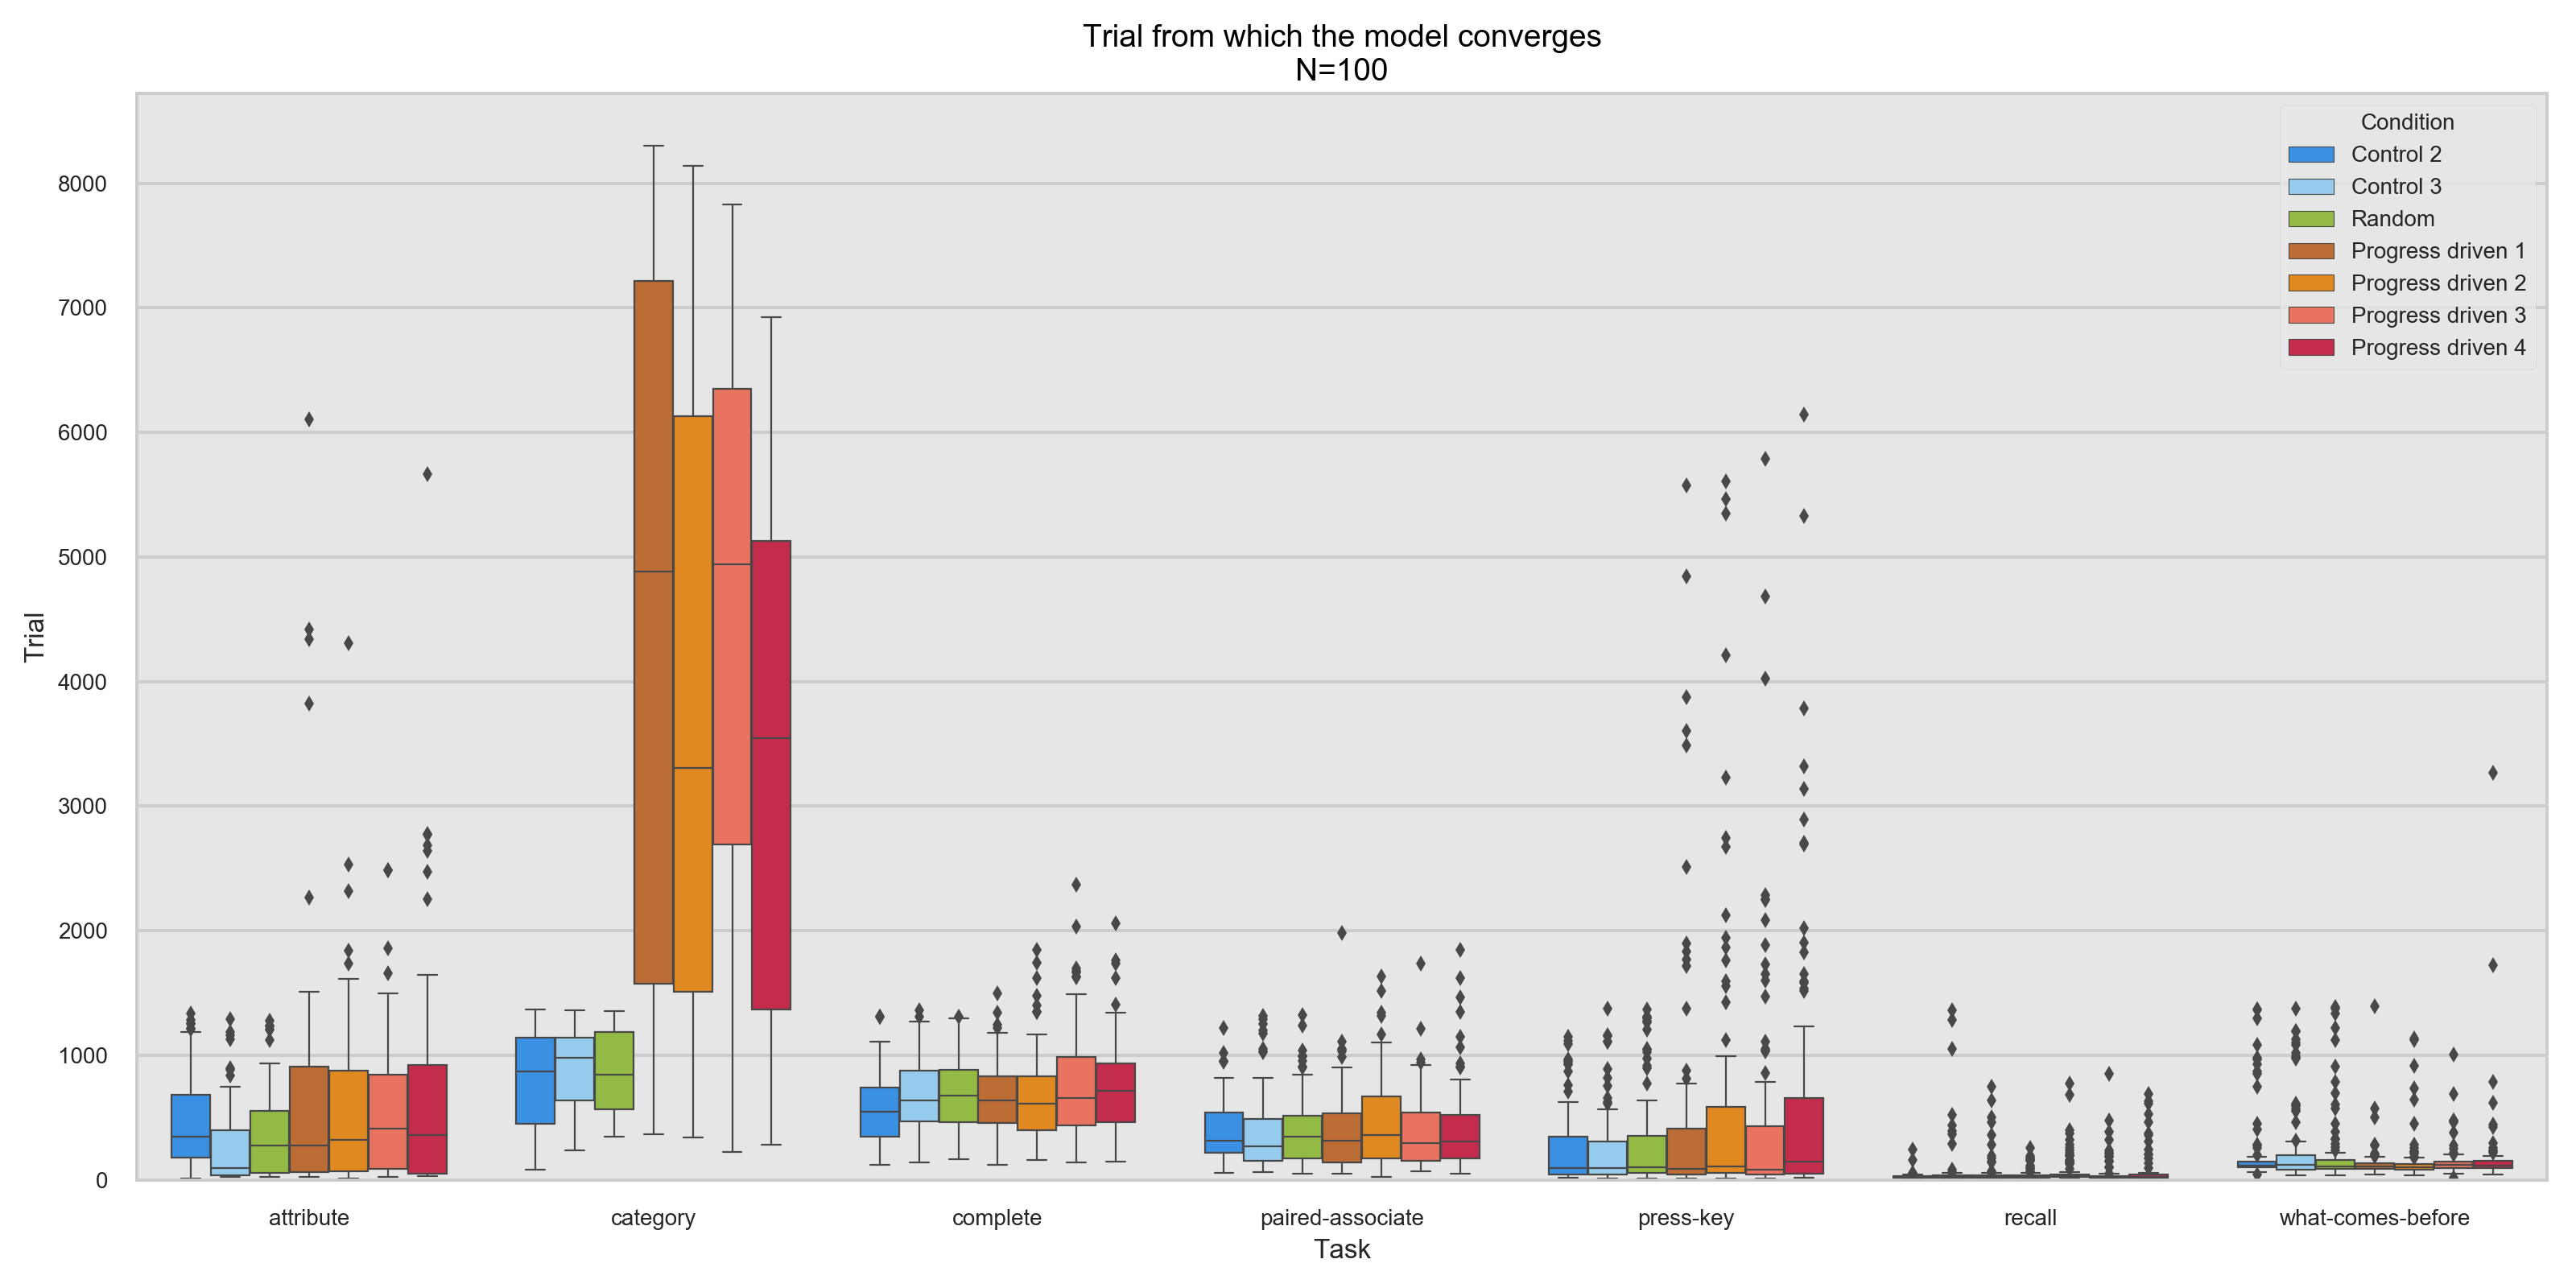

In [58]:
MEDIUM_SIZE = 10
BIG_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize= BIG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize= MEDIUM_SIZE)    # legend fontsize

fig, ax = plt.subplots(figsize = (16, 8))
#ax.set_facecolor('white')
#fig.patch.set_facecolor('white')

ax = sns.boxplot(x="Task", y="Trial", hue="Goal Selection", data=df2, linewidth = 0.8, whis= True,
               palette = {'Control 1': 'mediumslateblue', 'Control 2': 'dodgerblue', 
                           'Control 3':'lightskyblue','Random': 'yellowgreen',
                          'Progress driven 1':'chocolate', 
                          'Progress driven 2': 'darkorange', 
                          'Progress driven 3': 'tomato', 
                          'Progress driven 4':'crimson'})
sns.set_style("whitegrid", {"axes.facecolor": ".9"}) 
ax.set_title("Trial from which the model converges\nN=100",  fontsize =14, color= 'black')
l = ax.legend()
l.set_title('Condition')
#ax.set(ylim=(0, 200)) #to zoom
plt.subplots_adjust(top=0.9, bottom = 0.1, right=0.99, left=0.06)
#ax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in b.first_trial.items()], fontdict )

## Goal Dynamics

In [44]:
i=15
#df30 = goalDynamics(data=control10000.csv_sim['0'], window_size=50, func='Control 1')
df31 = goalDynamics(data=control1430.csv_sim[str(i)], window_size=50, func='Control 2')
df33=goalDynamics(data=control_noreset_test.csv_sim[str(i)], window_size=50, func='Control 3')
df34 = goalDynamics(data=random.csv_sim[str(i)], window_size=50, func='Random')
df35 = goalDynamics(data=accuderiv80.csv_sim[str(i)], window_size=50, func='Progress driven 3')
df3=pd.concat([ df31, df33, df34, df35])

<IPython.core.display.Javascript object>


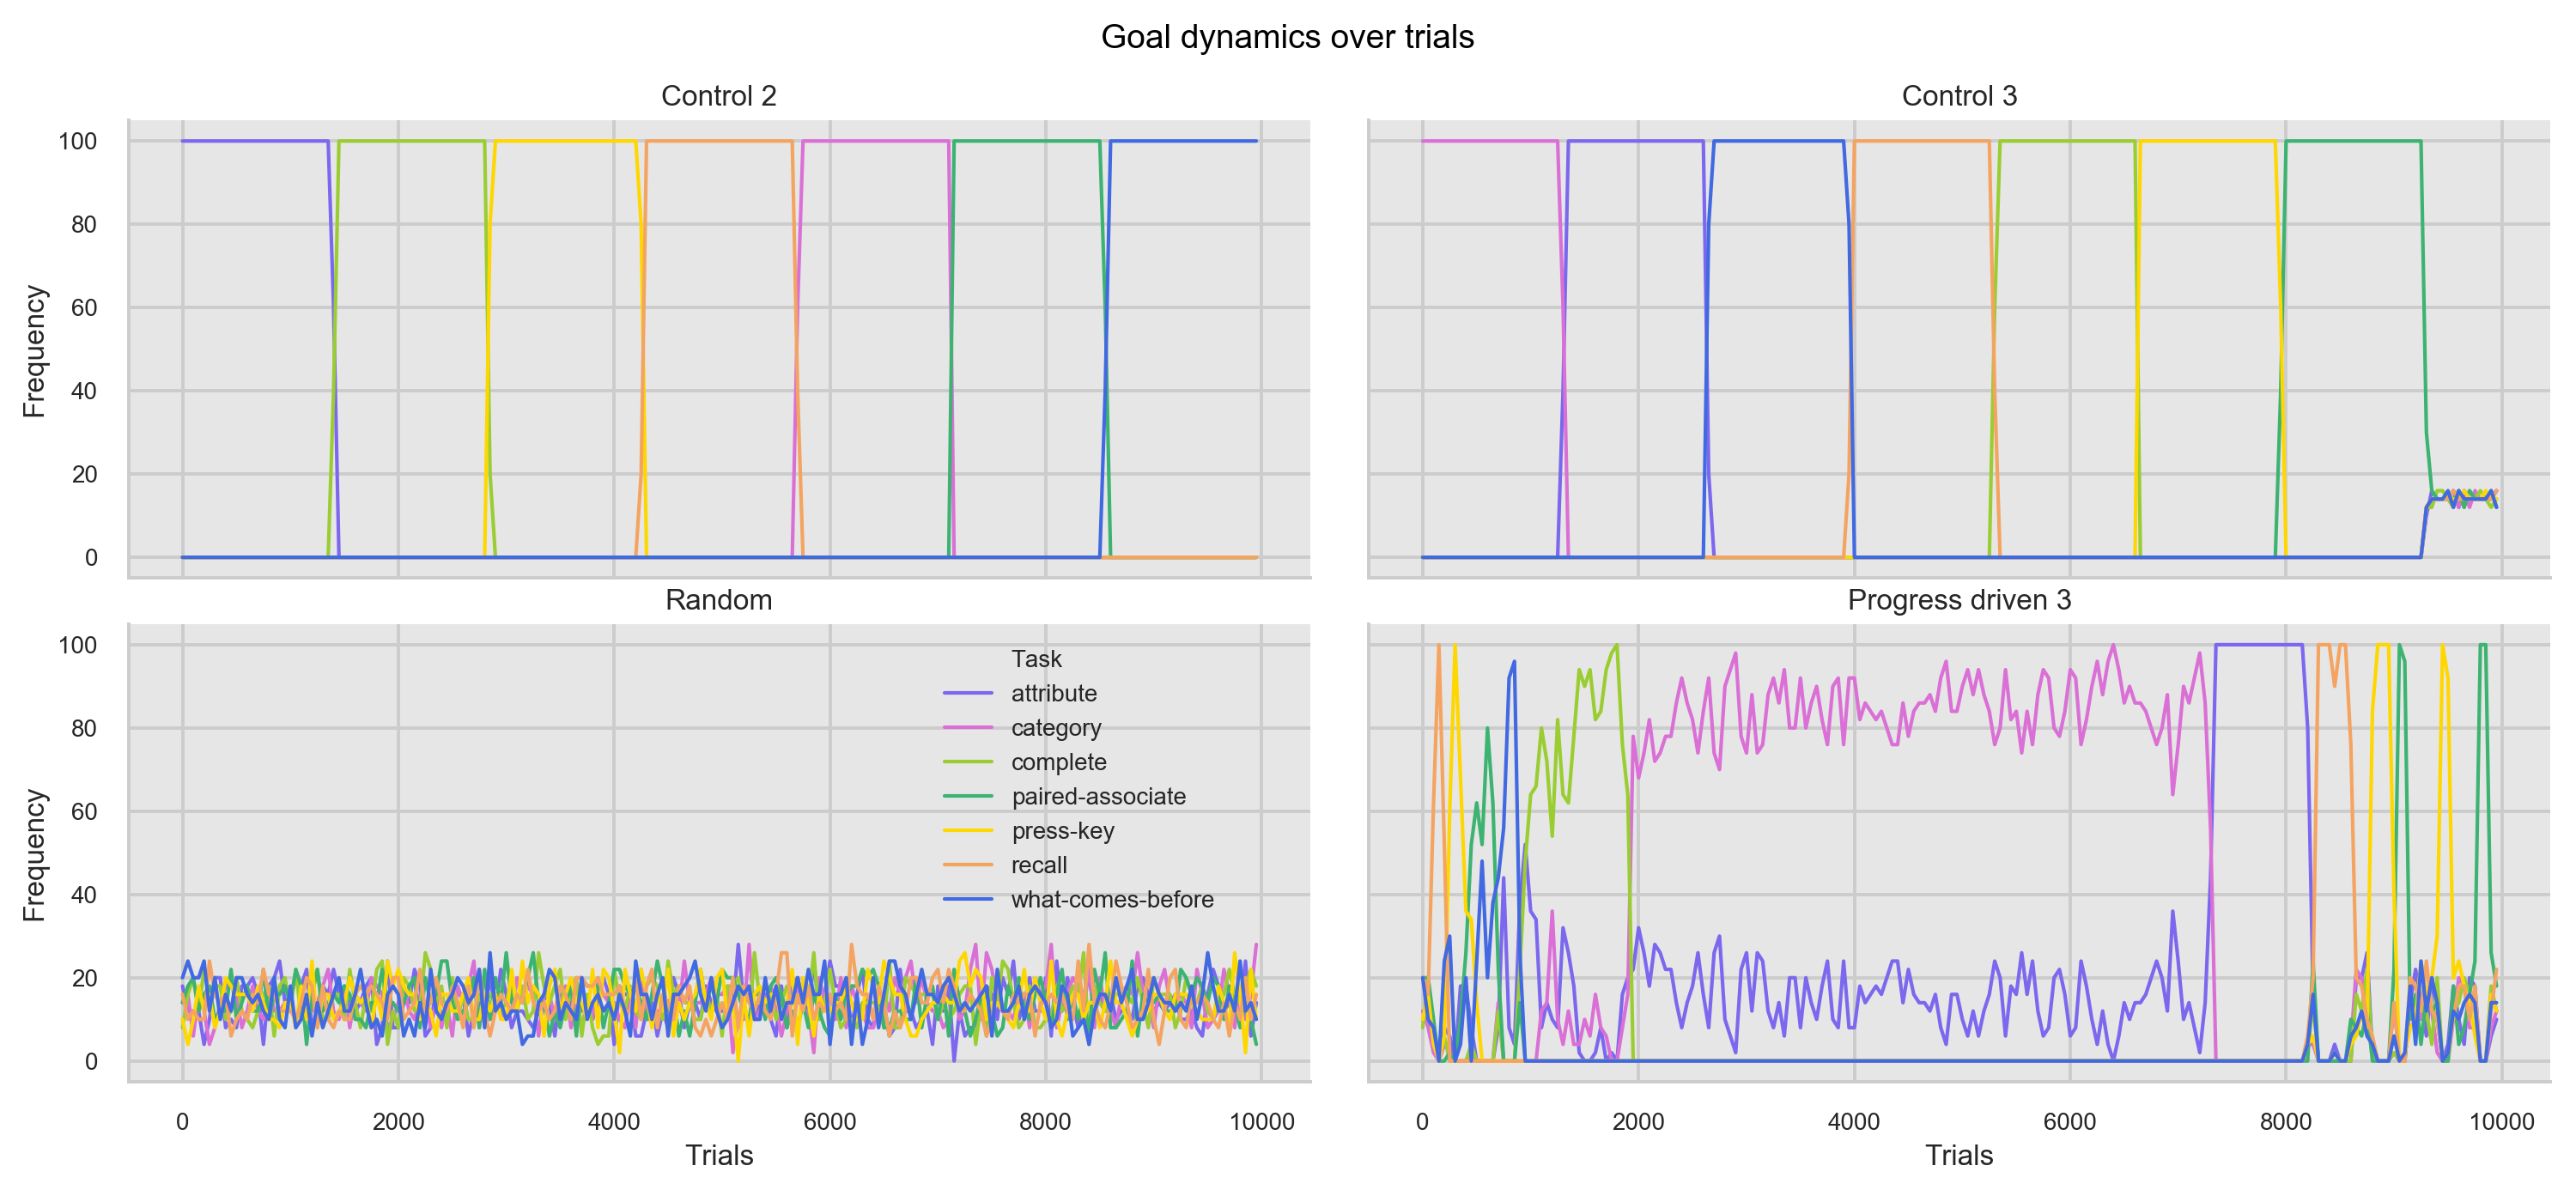

In [62]:
goal_dyna_graph(df3)

## Accuracy over trials

In [39]:
i=28

#df40 = control10000.csv_sim[str(i)]
#df40['Goal Selection'] = np.full((len(df40['Task'])), 'Control 1')

df41 = control1430.csv_sim[str(i)]
df41['Goal Selection'] = np.full((len(df41['Task'])), 'Control 2')

df43 = control_noreset_test.csv_sim[str(i)]
df43['Goal Selection'] = np.full((len(df43['Task'])), 'Control 3')

df44 = random.csv_sim[str(i)]
df44['Goal Selection'] = np.full((len(df44['Task'])), 'Random')

df46 = accuderiv50.csv_sim[str(i)]
df46['Goal Selection'] = np.full((len(df46['Task'])), 'Progress driven 2')

df47 = accuderiv80.csv_sim[str(i)]
df47['Goal Selection'] = np.full((len(df47['Task'])), 'Progress driven 3')

df4=pd.concat([ df43, df44])

<IPython.core.display.Javascript object>


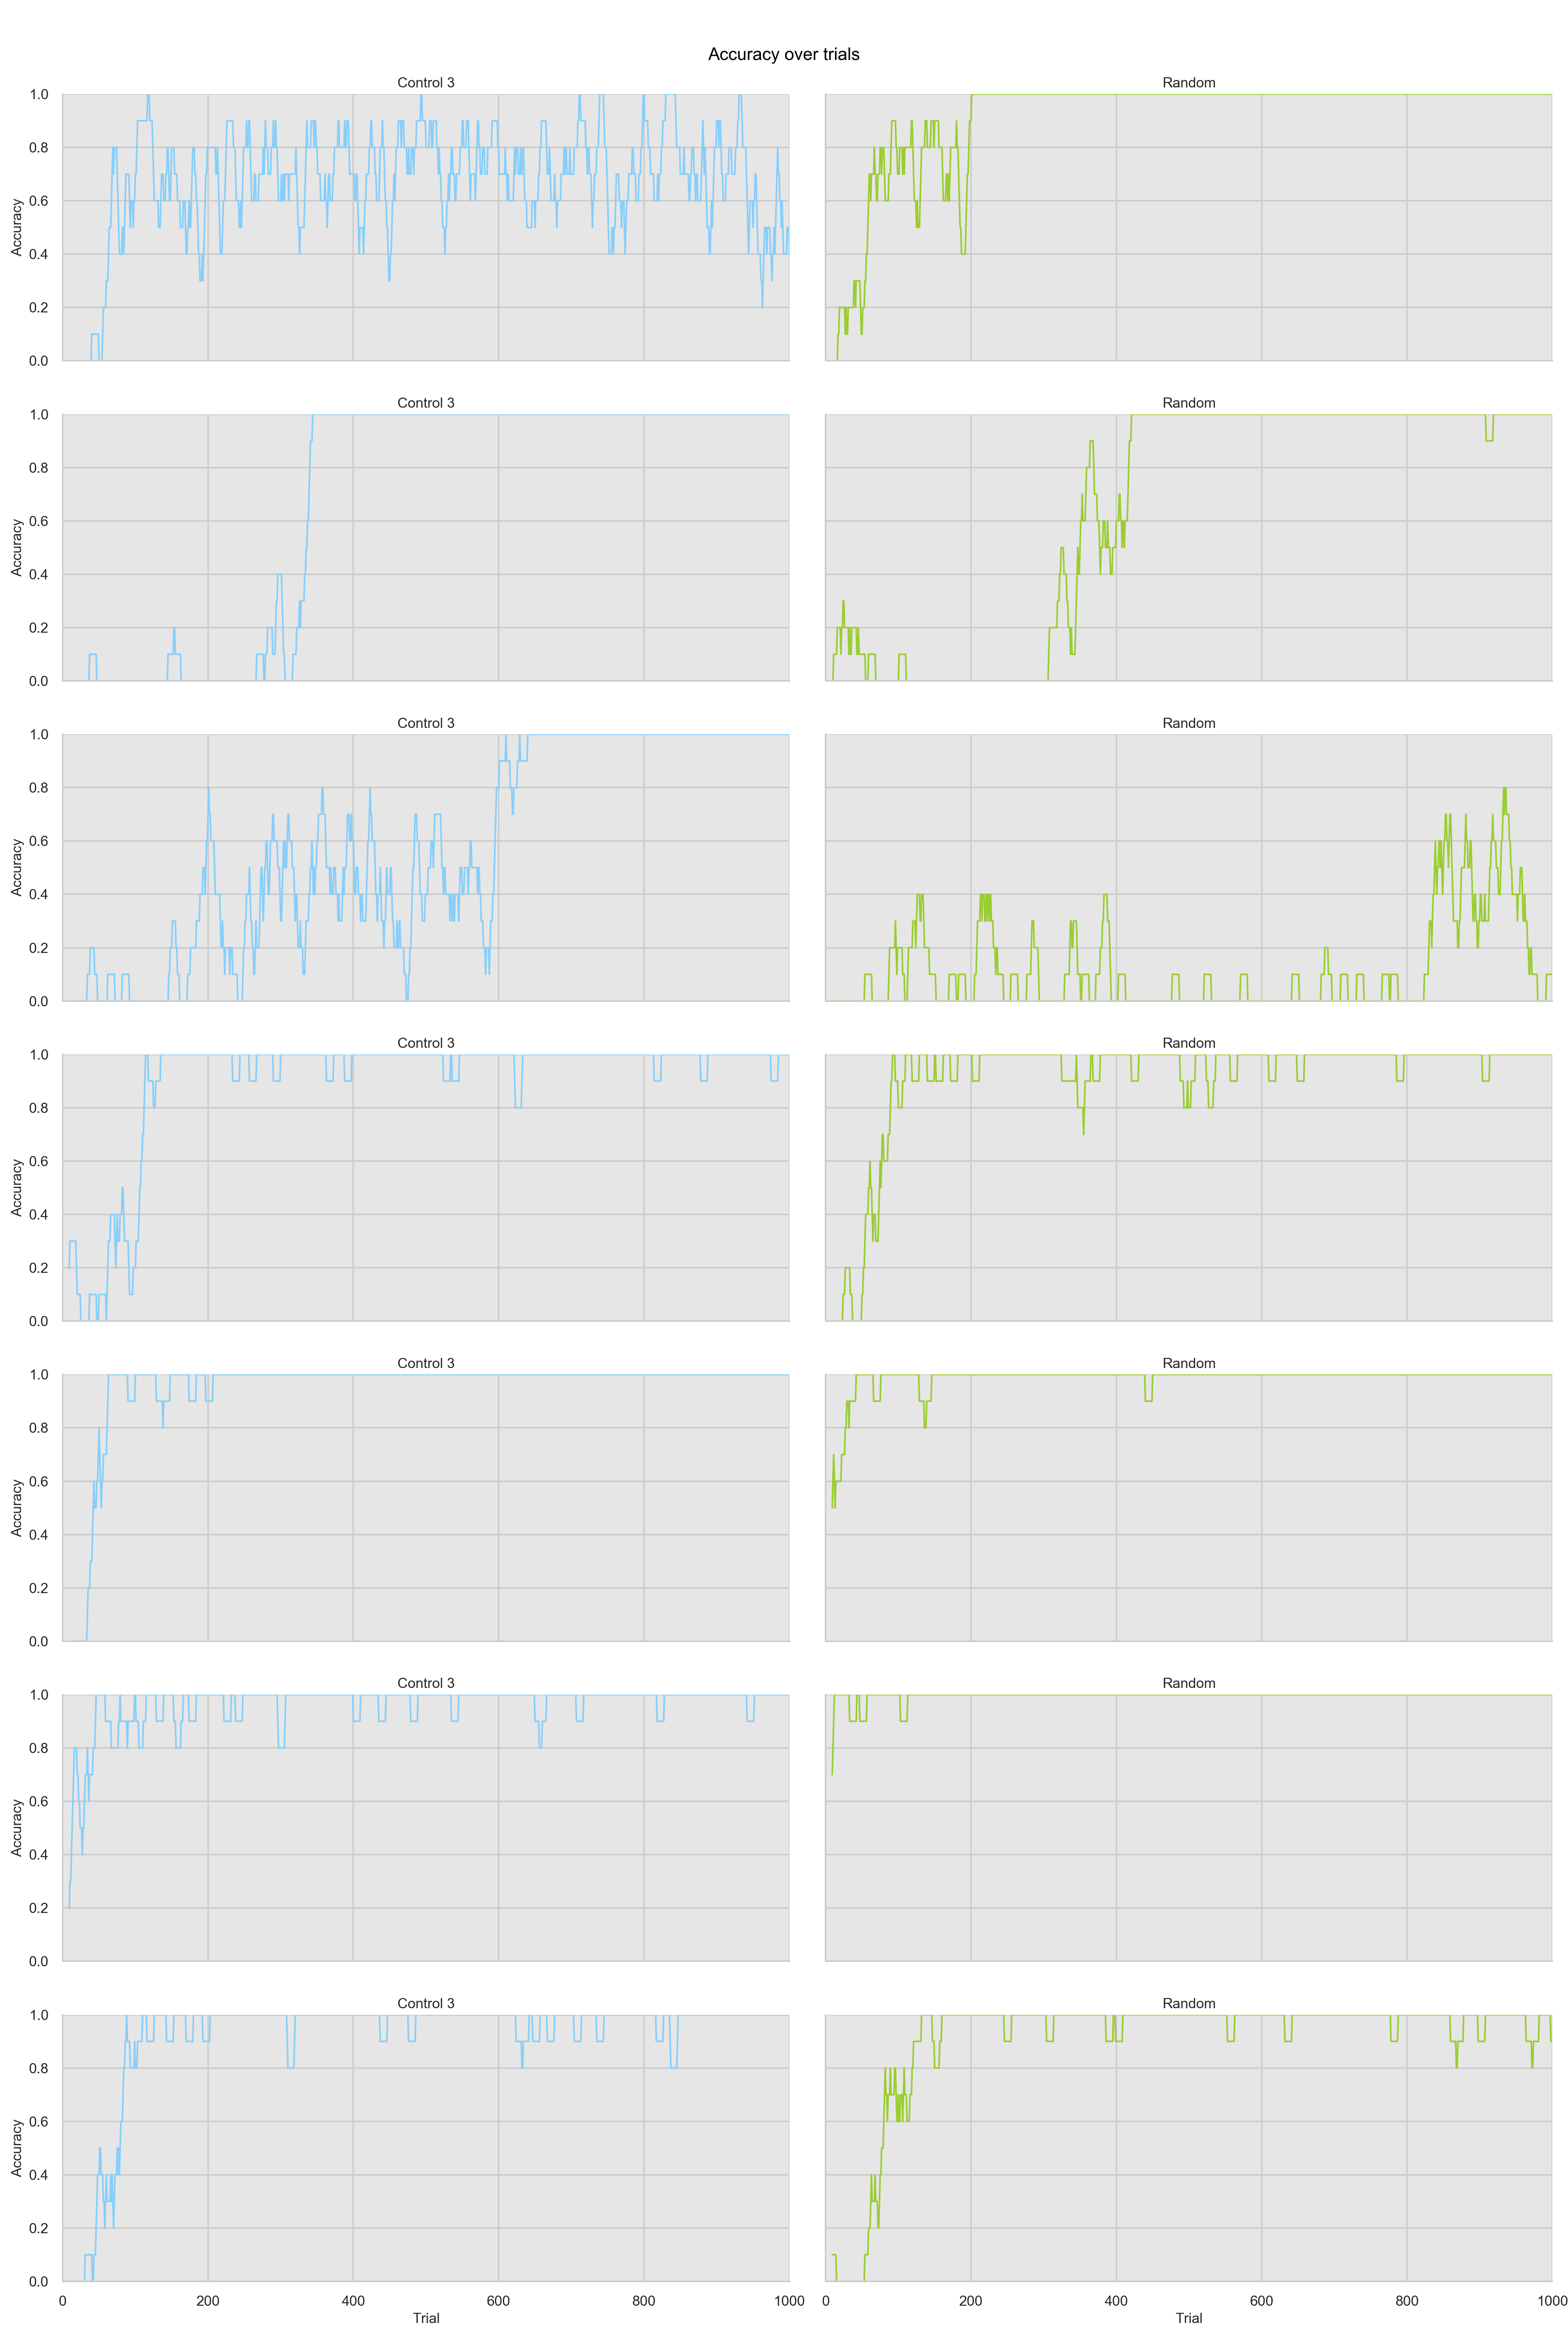

In [42]:
SMALL_SIZE = 8
MEDIUM_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize= MEDIUM_SIZE)    # legend fontsize

g = sns.relplot(x= 'Trial', y='Accuracy', hue='Goal Selection', col='Goal Selection',
                row='Task', height=5, aspect=.7, kind="line", data=df4, legend=False,
                palette = {'Control 1': 'mediumslateblue', 'Control 2': 'dodgerblue', 
                           'Control 3':'lightskyblue','Random': 'yellowgreen',
                          'Progress driven 1':'chocolate', 
                          'Progress driven 2': 'darkorange', 
                          'Progress driven 3': 'tomato', 
                          'Progress driven 4':'crimson'})
# Control the title of each facet
g.set_titles("{col_name}", fontsize=11)

#Standardized y-axis
plt.ylim(0, 1)
plt.xlim(0, 1000)
# Add a title for the whole plot
plt.subplots_adjust(top=0.96, bottom = 0.03, right=0.99, left=0.04, hspace=0.2, wspace=0.05)
g.fig.suptitle('Accuracy over trials', fontsize =16, color= 'black')
g.fig.set_size_inches(20,30)
#fig.tight_layout()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


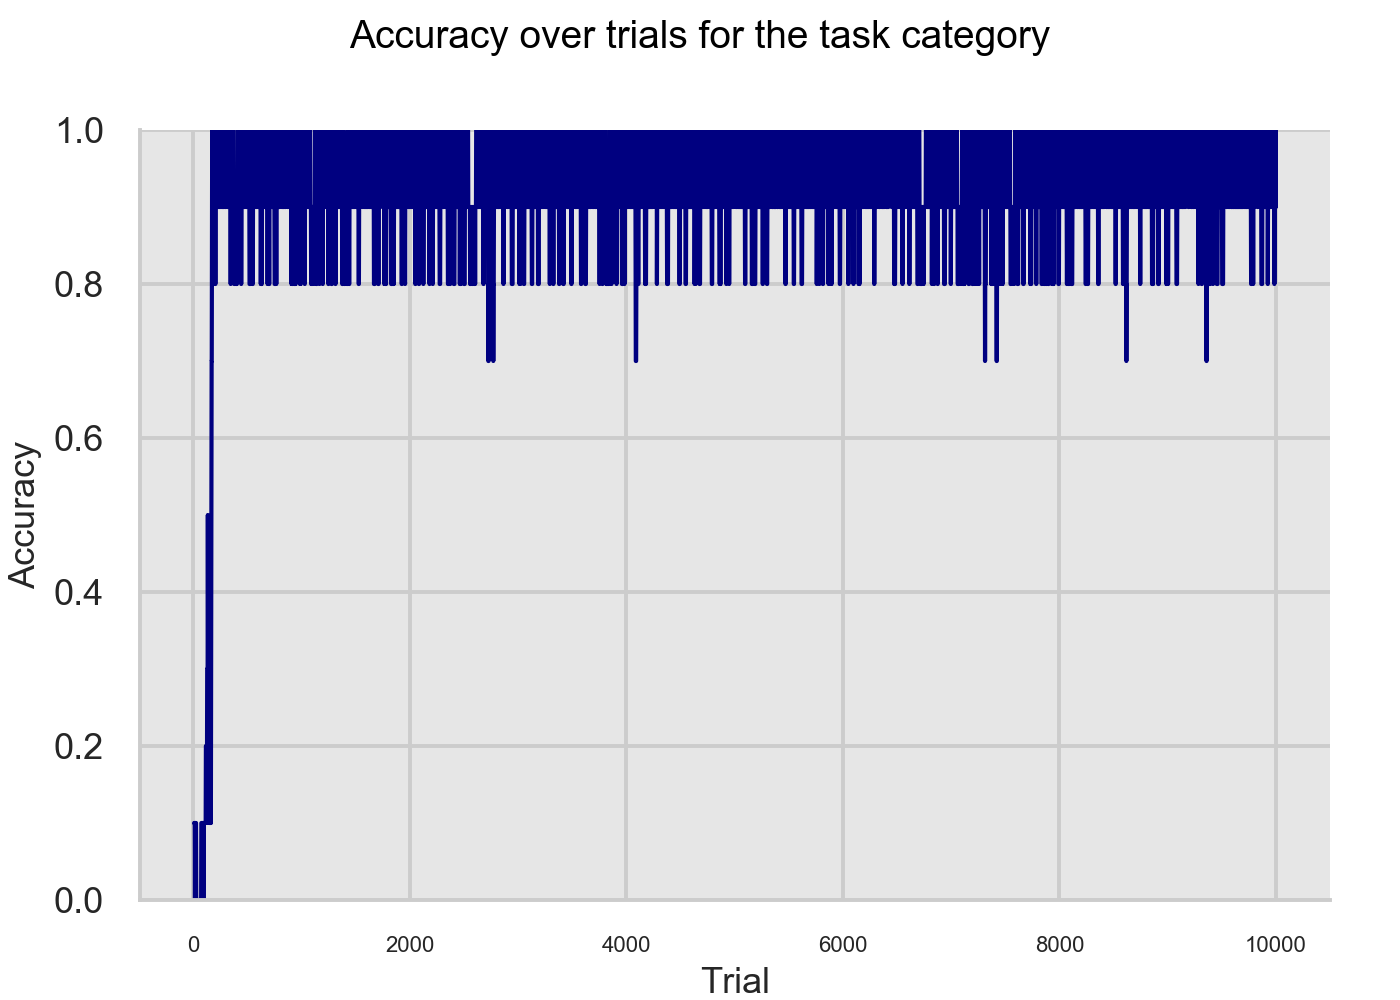

In [948]:
task='category'
i=23

df40 = control10000.csv_sim[str(i)]
df40 = df40.loc[df40.Task==task]
df40['Goal Selection'] = np.full((len(df40['Task'])), 'Control 1')

g = sns.relplot(x= 'Trial', y='Accuracy', hue='Goal Selection', height=5, aspect=.7, kind="line", 
                data=df40, legend=False, palette = {'Control 1': 'mediumslateblue'})

#Standardized y-axis
plt.ylim(0, 1)
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.87, bottom = 0.1, right=0.95, left=0.1)
g.fig.suptitle('Accuracy over trials for the task '+task, fontsize =14, color= 'black')
g.fig.set_size_inches(7,5)
#fig.tight_layout()

## Transitions between primitive operations

Task                                                           category
Time                                                           0.661983
goalBLActivation                                                1.01746
reachGoal                                                         False
Accuracy                                                            0.2
retrievedOperators    23809.40_V1toRT2+C1toRT1-23809.53_C1altToRT1-2...
Goal Selection                                        Progress driven 3
Name: 1847, dtype: object
Task                                                           category
Time                                                             1.5217
goalBLActivation                                                1.00948
reachGoal                                                         False
Accuracy                                                            0.3
retrievedOperators    23167.93_C1toRT1-23168.10_RT1equalC1+C1altToRT...
Goal Selection                        

<IPython.core.display.Javascript object>


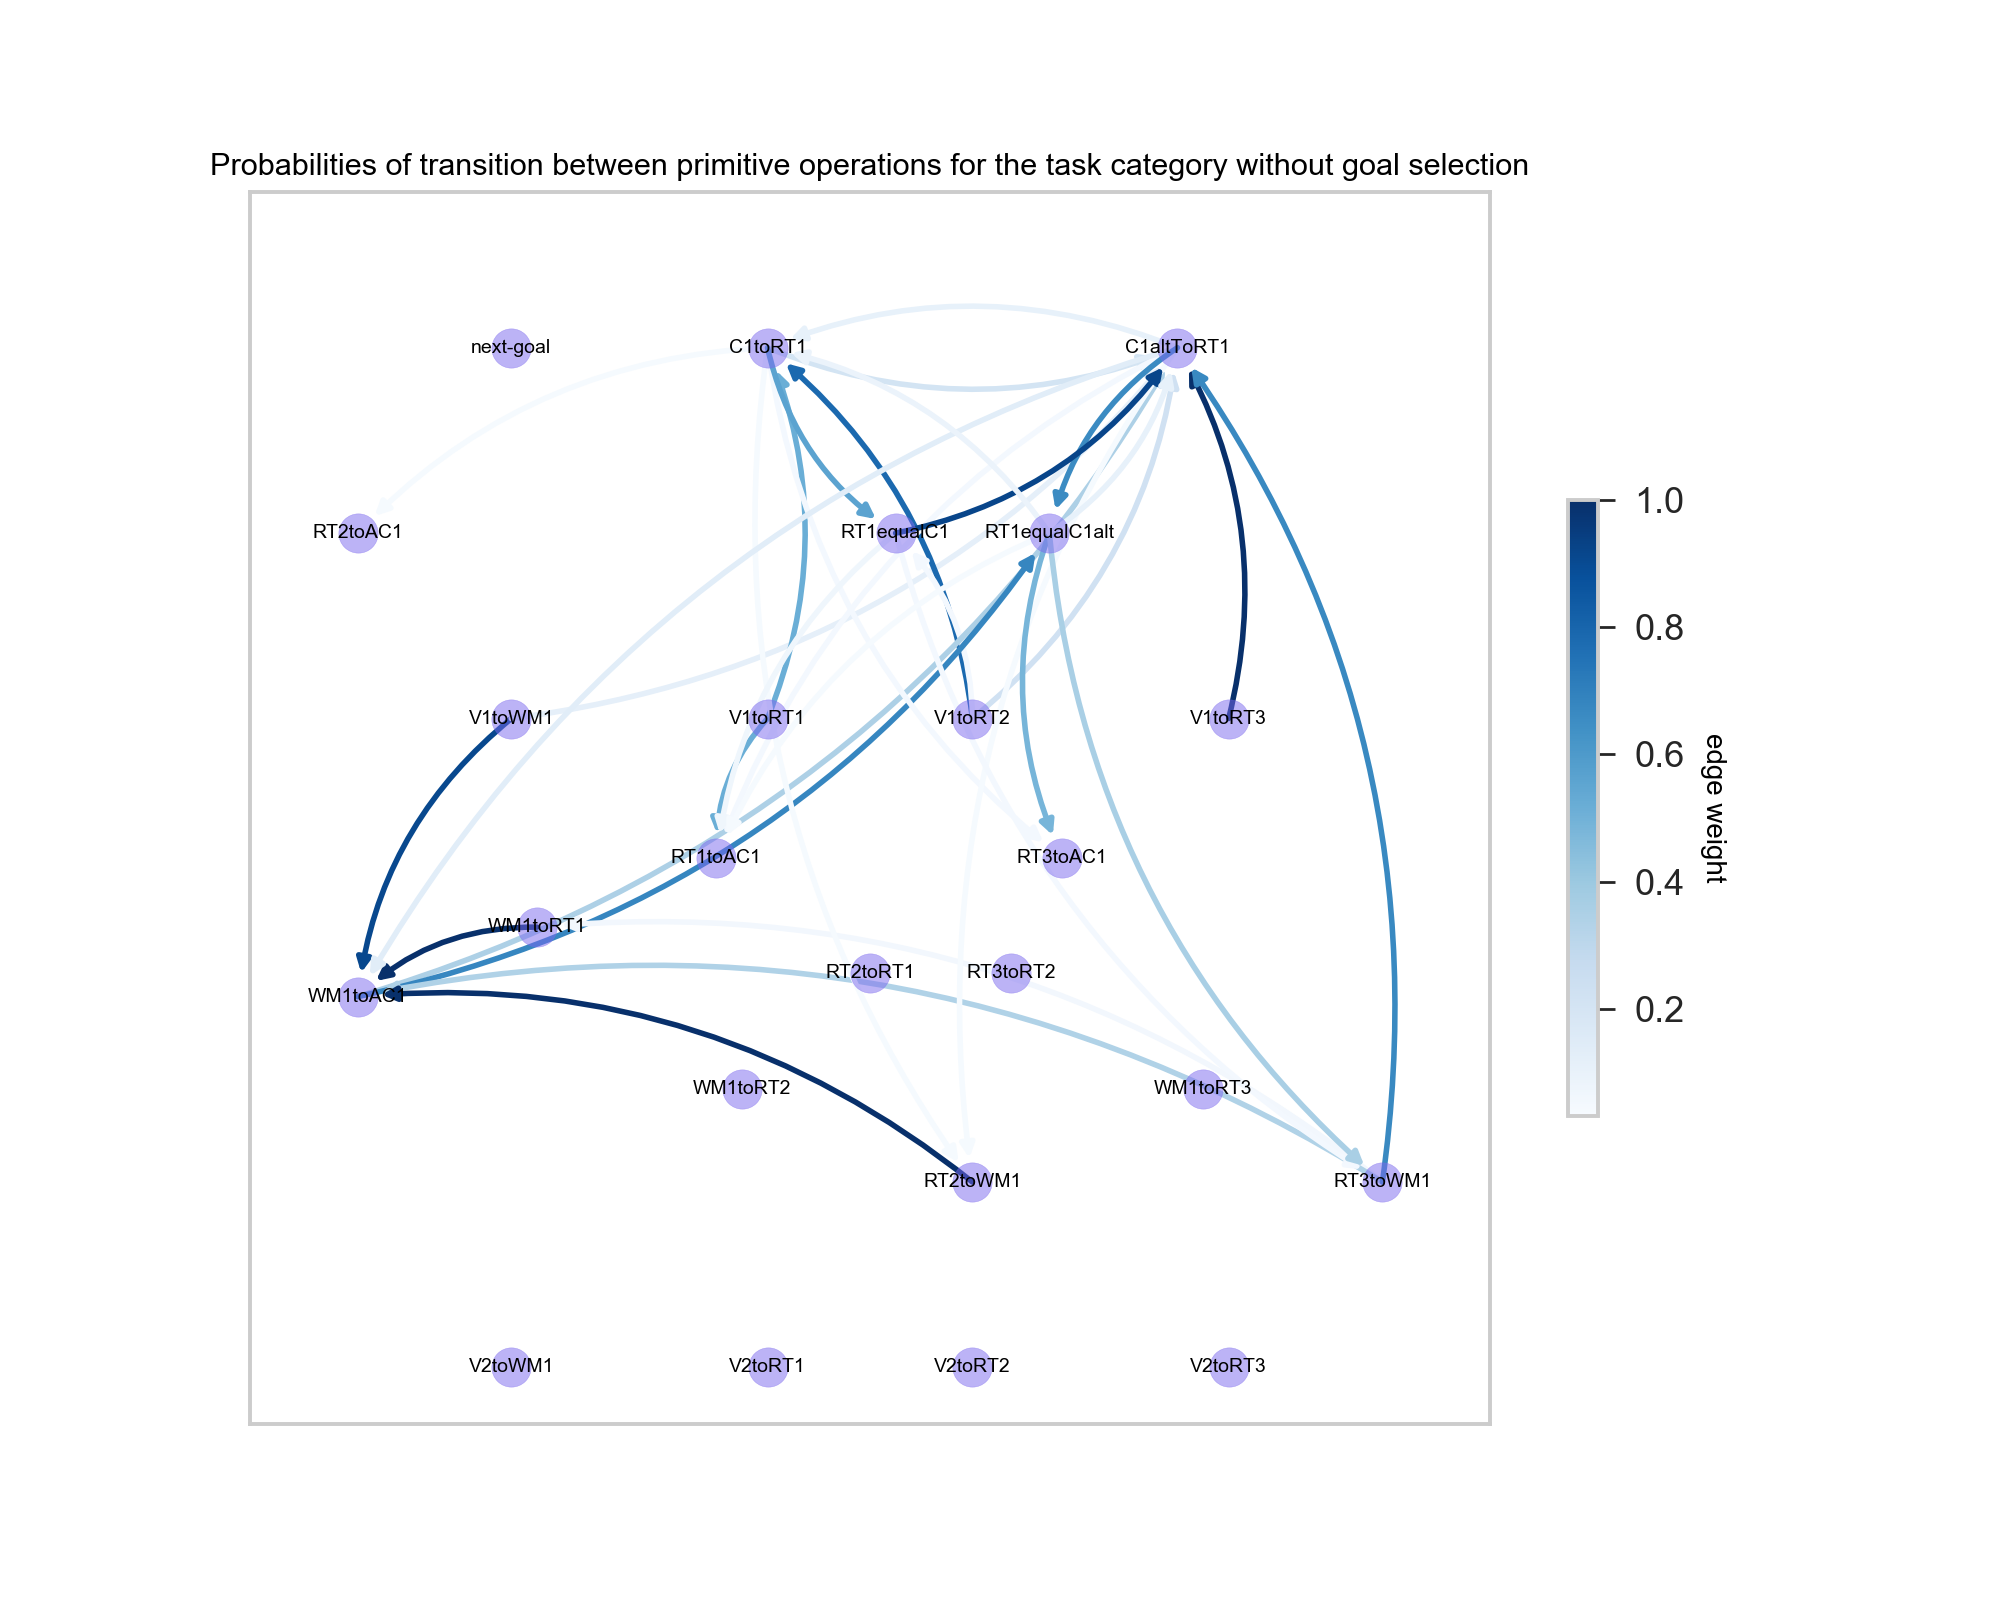

In [158]:
i=15
t = 'category'
#dat=control_noreset_test.csv_sim[str(i)]
dat=accuderiv80.csv_sim[str(i)]
#dat=random.csv_sim[str(i)]
#dat=control1250.csv_sim[str(i)]
table = prims_seq_control(data = dat , dict_primitives= dict_prims, task=t , n=3000, N=3100)
static_prims(df=table , task=t)

71 29


<IPython.core.display.Javascript object>


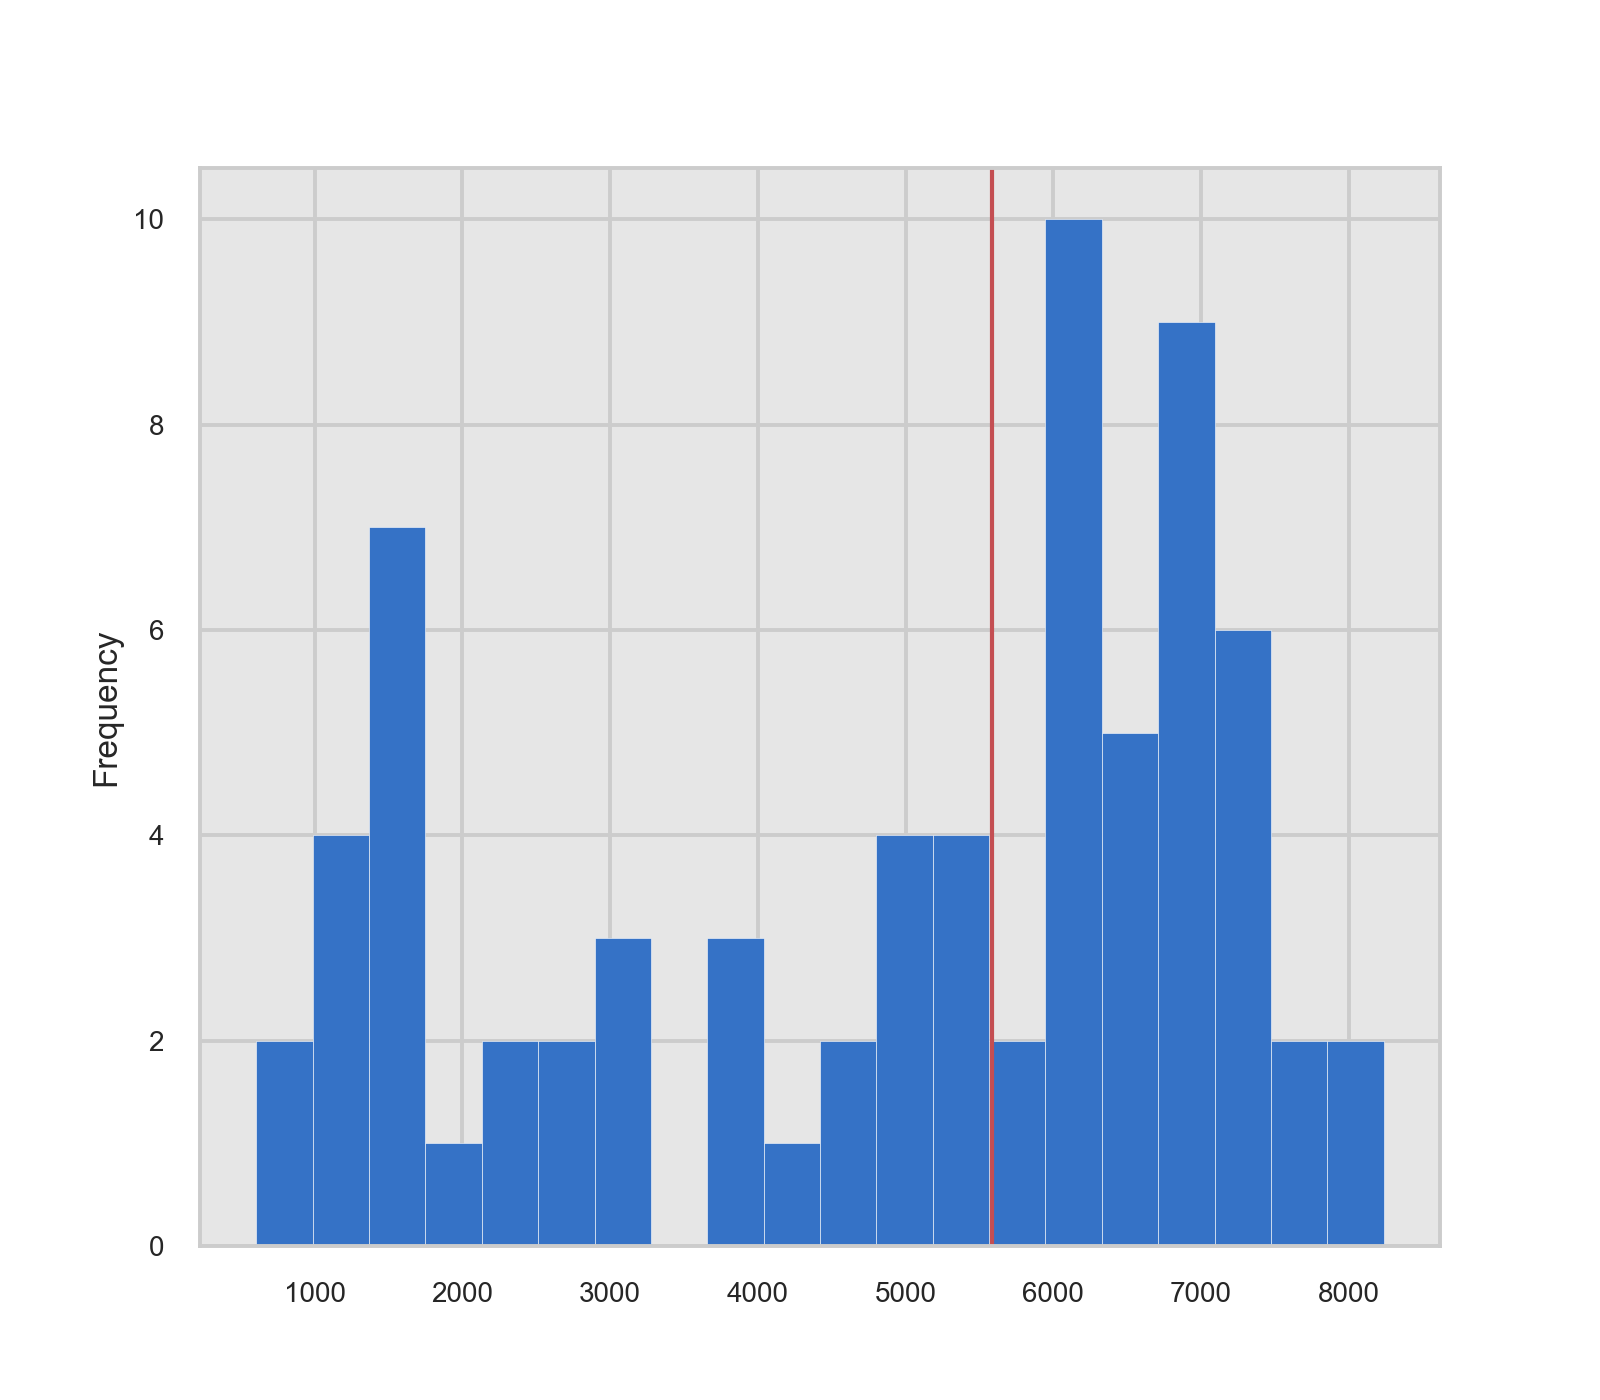

<IPython.core.display.Javascript object>


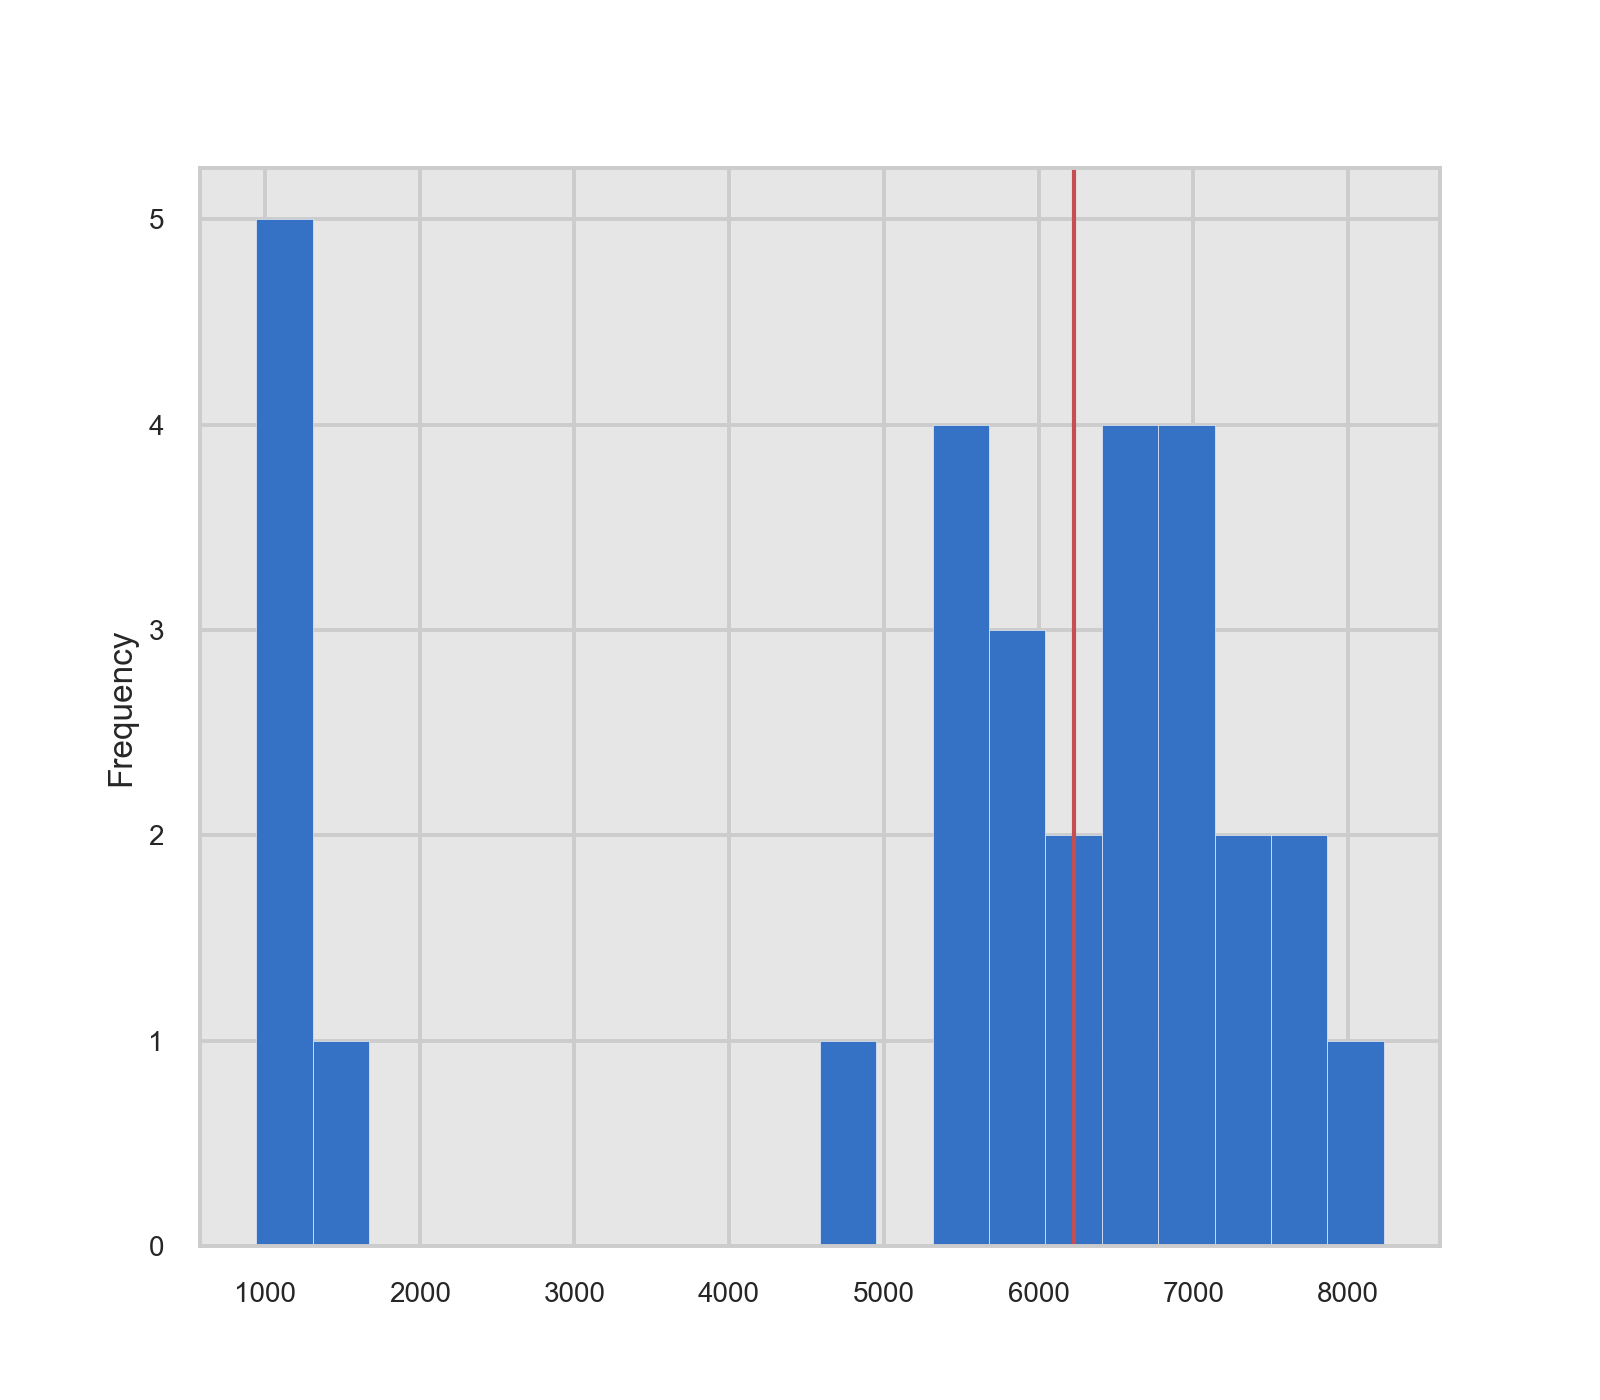

In [131]:
df = accuderiv80.category
df1 = df.loc[df.Convergence==True, ['NumberOfTrials']]
df2 = df.loc[df.Convergence==False, ['NumberOfTrials']]
print(len(df1), len(df2))
ax = df1.plot.hist(bins = 20, legend=None)
ax.axvline(int(df1.median()), color='r', linestyle='-')
ax2=df2.plot.hist(bins = 20, legend=None)
ax2.axvline(int(df2.median()), color='r', linestyle='-')


<IPython.core.display.Javascript object>


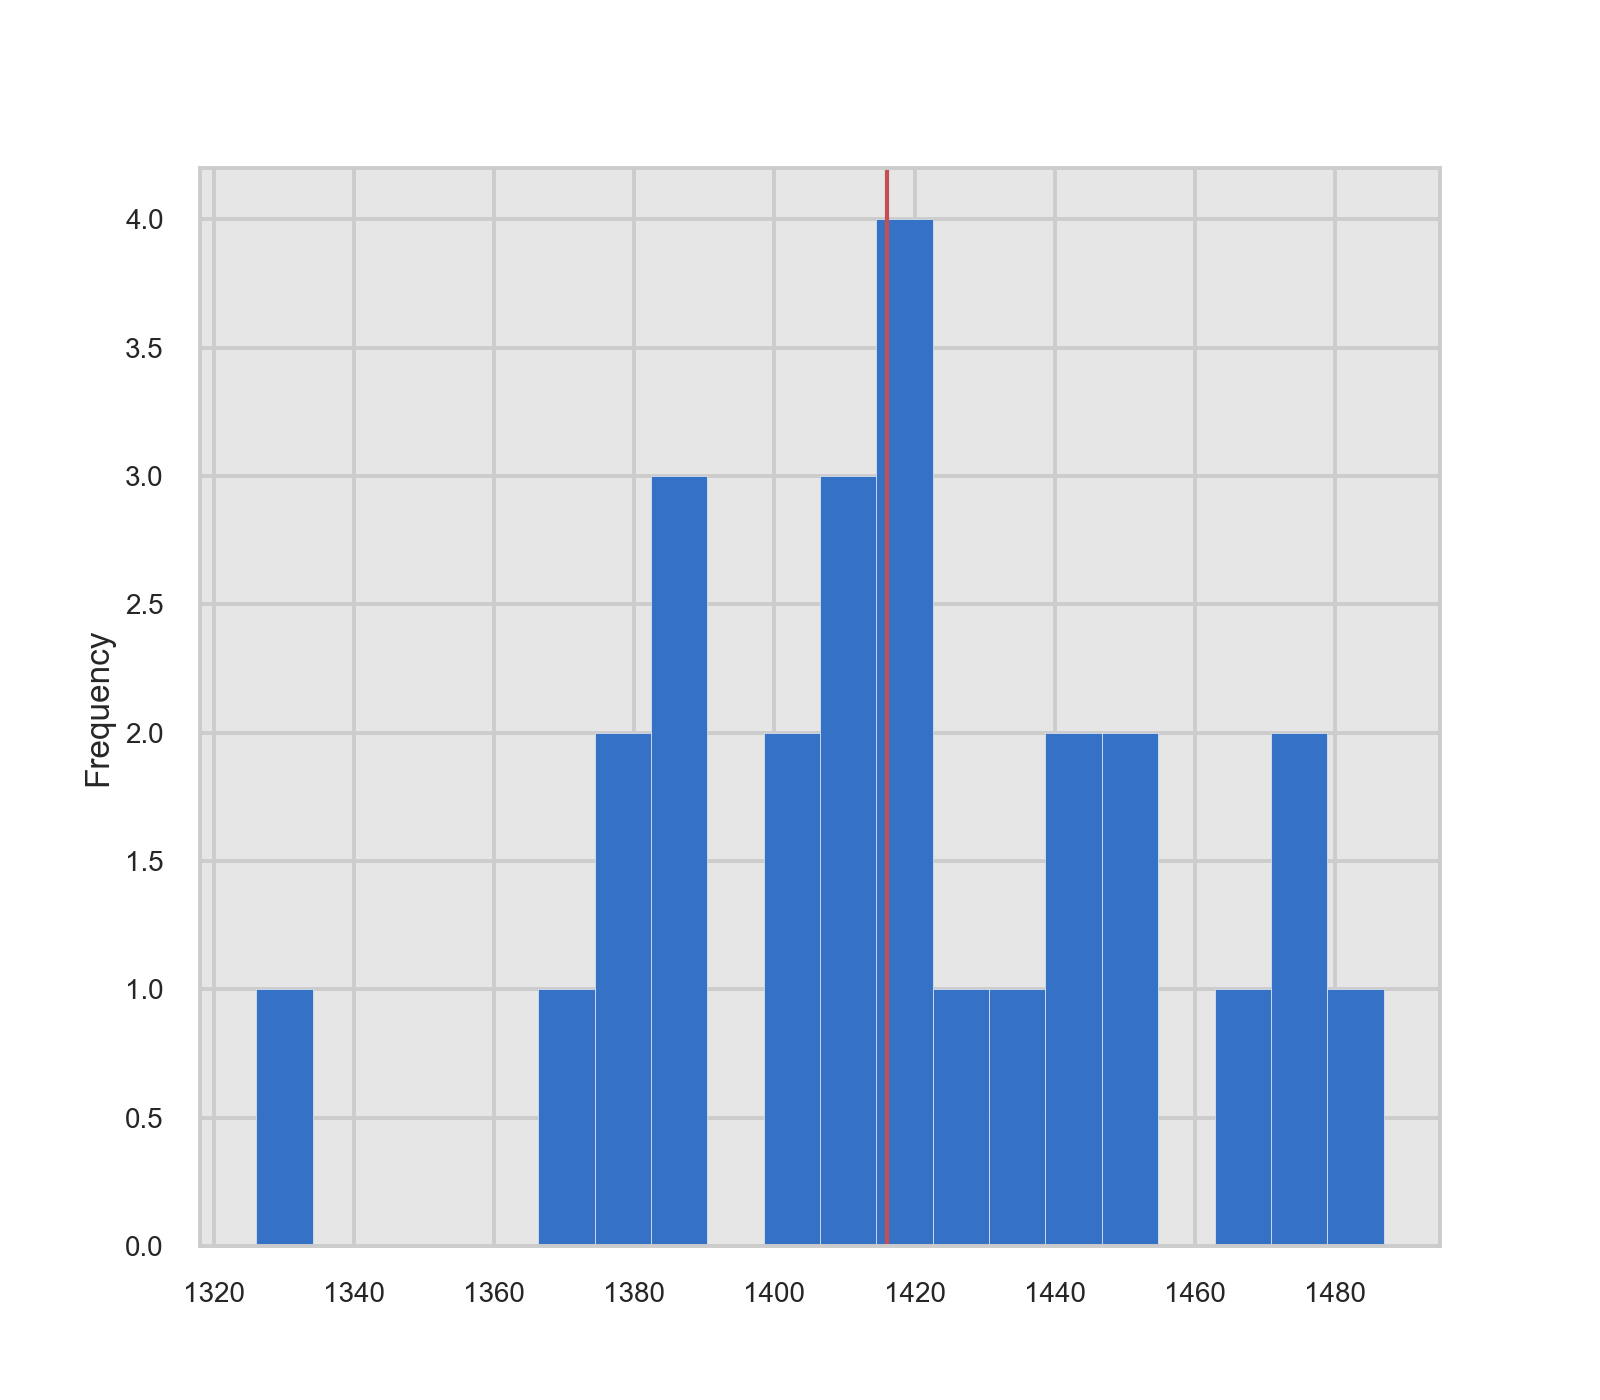

<IPython.core.display.Javascript object>


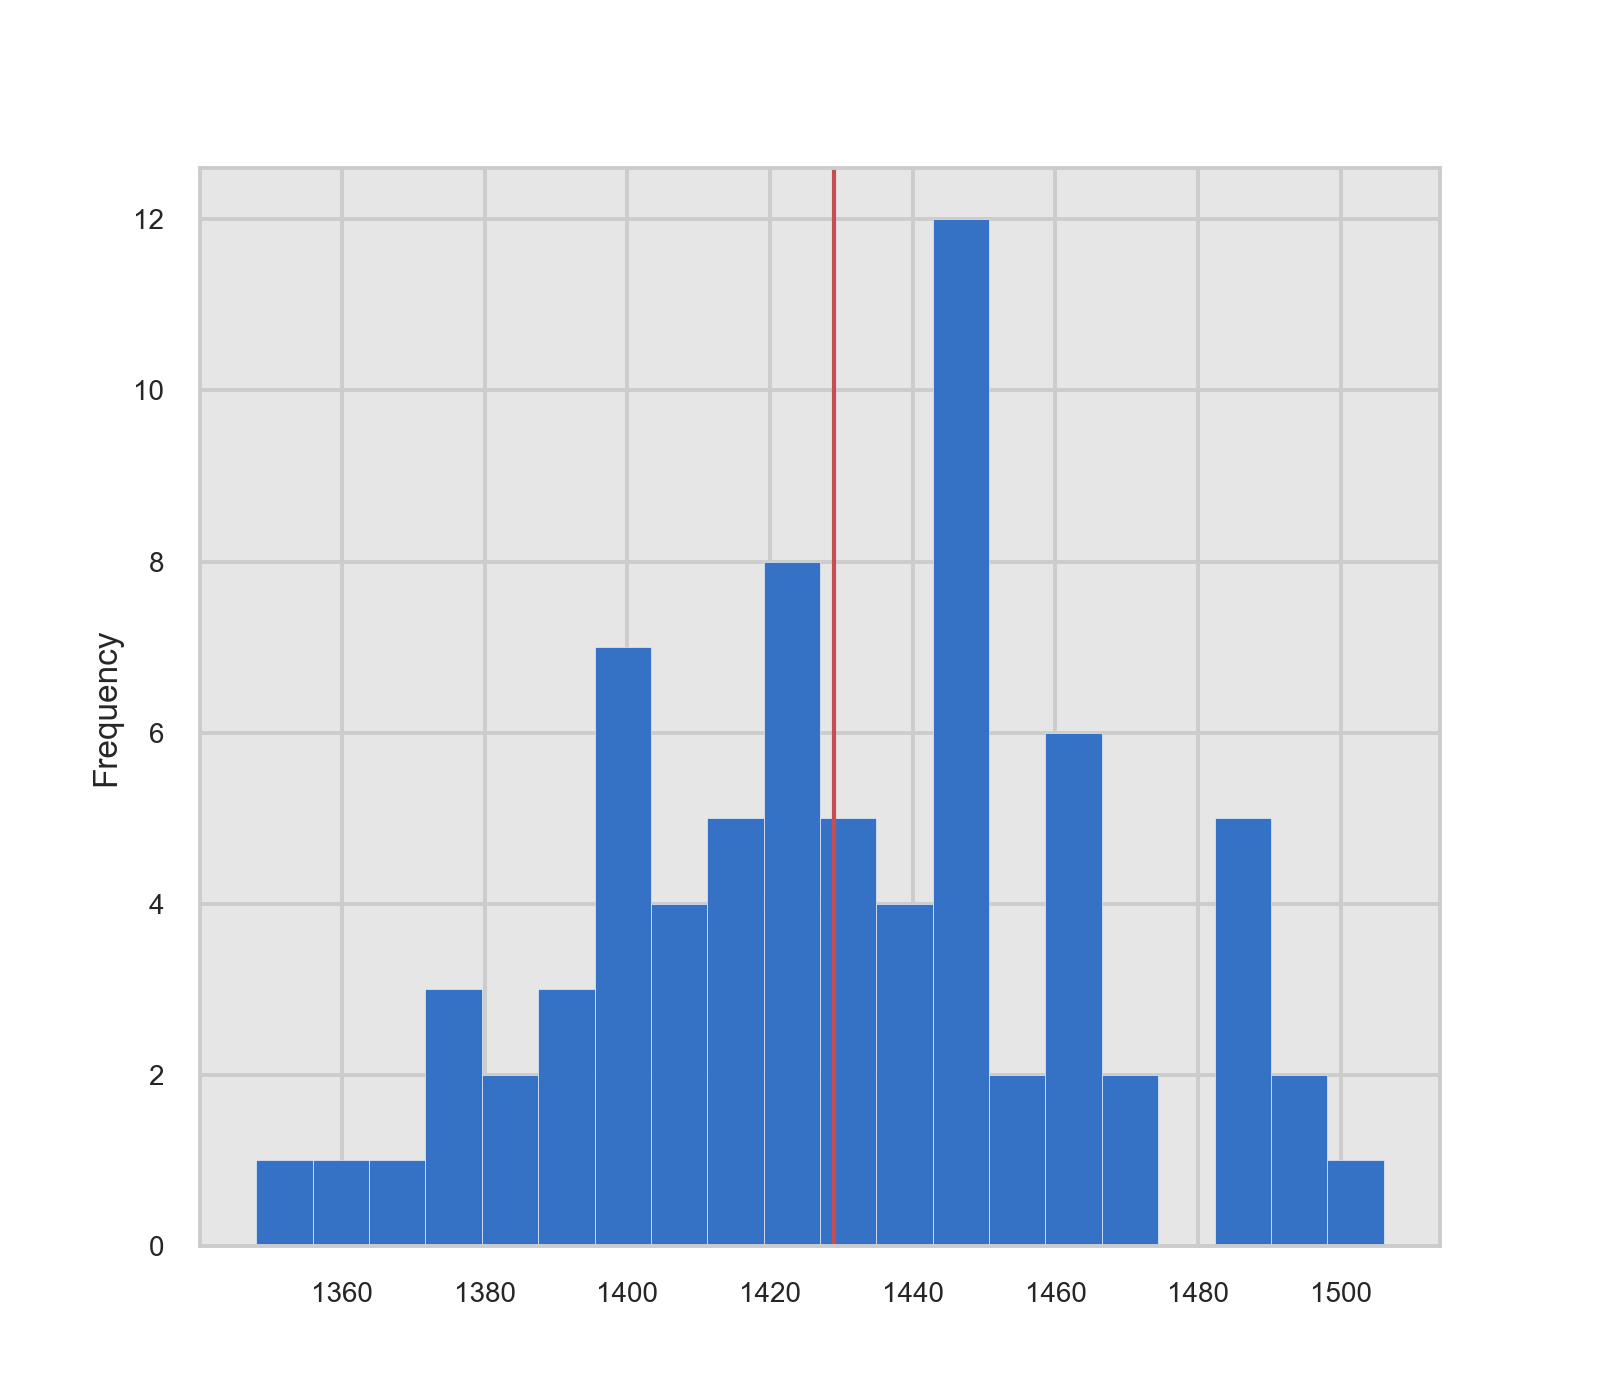

26 74


In [134]:
d = random.category
d1 = d.loc[d.Convergence==True, ['NumberOfTrials']]
d2 = d.loc[d.Convergence==False, ['NumberOfTrials']]
ax3 = d1.plot.hist(bins = 20, legend=None)
ax3.axvline(int(d1.median()), color='r', linestyle='-')
ax4=d2.plot.hist(bins = 20, legend=None)
ax4.axvline(int(d2.median()), color='r', linestyle='-')
print(len(d1), len(d2))